In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.style.use('dark_background')


In [113]:
class Environment:
    """
    initialize the grid world environemnt
    """
    def __init__(self, height=7, width=7):
        
        # setting up the grid world
        self.height = height
        self.width = width
        self.rewards = np.zeros((self.height, self.width)) - 1
        self.rewards[0,0] = 20
        
        # set random start state (or location) for the agent
        self.current_state = (self.height-1, 0)
        
        # set states (or locations) for the bomb and the gold
        self.gold_state = (0,0)
        self.terminal_states = [self.gold_state]
        self.obstacle = [(2,0),(2,1),(2,2),(2,3),(2,4),(2,5)]
        # set grid rewards for bomb and gold states
        
        # the set of available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']   
        
    def get_actions(self):
        """
        return the set of actions (A)
        """
        return self.actions
    
    def get_agent_location(self):
        """
        returns the current location of the agent marked on the grid world as ``1''
        """
        grid_world = np.zeros((self.height, self.width))
        grid_world[self.current_state[0], self.current_state[1]] = 1
        return grid_world
    
    def get_reward(self, state):
        """
        returns the reward for the input state
        """
        return self.rewards[state[0], state[1]]
        
    
    def delta(self, action):
        """
        moves the agent in the specified direction: if agent is at a border then it stays still
        but takes negative reward and the function returns the immediate reward for the action
        """
        # store the location before taking action
        last_state = self.current_state
        
        # move UP
        if action == 'UP':
            # if the agent is at the top border, stay still, collect negative reward
            new_pos = (last_state[0]-1,last_state[1])
            if new_pos in self.obstacle:
                reward = self.get_reward(last_state)
            elif last_state[0] == 0:
                reward = self.get_reward(last_state)
            else:
                self.current_state = (self.current_state[0] - 1, self.current_state[1])
                reward = self.get_reward(self.current_state)
                
        # move DOWN
        elif action == 'DOWN':
            new_pos = (last_state[0] +1,last_state[1])
            # if the agent is at the bottom border, stay still, collect negative reward
            if new_pos in self.obstacle:
                reward = self.get_reward(last_state)
            elif last_state[0] == self.height - 1:
                reward = self.get_reward(last_state)
            else:
                self.current_state = (self.current_state[0] + 1, self.current_state[1])
                reward = self.get_reward(self.current_state)
            
        # move LEFT
        elif action == 'LEFT':
            new_pos = (last_state[0],last_state[1]-1)

            # if the agent is at the left border, stay still, collect negative reward
            if new_pos in self.obstacle:
                reward = self.get_reward(last_state)
            elif last_state[1] == 0:
                reward = self.get_reward(last_state)
            else:
                self.current_state = (self.current_state[0], self.current_state[1] - 1)
                reward = self.get_reward(self.current_state)

        # move RIGHT
        elif action == 'RIGHT':
            # of the agent is at the right border, stay still, collect negative reward
            new_pos = (last_state[0],last_state[1]+1)
            if new_pos in self.obstacle:
                reward = self.get_reward(last_state)
            elif last_state[1] == self.width - 1:
                reward = self.get_reward(last_state)
            else:
                self.current_state = (self.current_state[0], self.current_state[1] + 1)
                reward = self.get_reward(self.current_state)

        return reward
    
    def check_state(self):
        """
        check if the agent is in a terminal state (gold or bomb):
        if so return 'TERMINAL', otherwise return 'NONTERMINAL'
        """
        current_state_type = 'NONTERMINAL'
        if self.current_state in self.terminal_states:
            current_state_type ='TERMINAL'
        
        return current_state_type

In [271]:
class RandomAgent:
    def __init__(self):
        np.random.seed(7)
        self.time = -1
    # select a random action
    def select_action(self, actions,state):
        """
        returns a random action
        """
        self.time += 1 
        return np.random.choice(actions)  
    def reset(self):
        self.time = -1
        return

In [272]:
class optimalPath:
    def __init__(self):
        self.choices = ['RIGHT','RIGHT','RIGHT','RIGHT','RIGHT','RIGHT','UP','UP','UP','UP','UP','UP','LEFT','LEFT','LEFT','LEFT','LEFT','LEFT']
        self.time = -1
    # select a random action
    def select_action(self, actions,state):
        """
        returns a random action
        """
        self.time += 1
        return self.choices[self.time]
    def reset(self):
        self.time = -1
        return

In [287]:
class QLearningAgentDet:
    def __init__(self, epsilon=0, gamma=1):
        """
        initialises the Deterministic Q-Learning Agent
        """
        self.time = -1
        np.random.seed(7)
        qs = [[20., 19., 18., 17, 16, 15, 14],
       [19, 18., 17, 16, 15, 14, 13],
       [ 0.,  0.,  0.,  0.,  0.,  0., 12],
       [5, 6, 7, 8, 9, 10, 11],
       [4, 5, 6, 7, 8, 9, 10],
       [3, 4, 5, 6, 7, 8, 9],
       [2, 3, 4, 5, 6, 7, 8]]
        self.Qs = np.pad(qs, 1, mode='constant')
        self.Q = dict() # store all Q-values in dictionary of dictionaries 
        for x in range(7): # loop through all possible grid spaces, create sub-dictionary for each grid
            for y in range(7):
                self.Q[(x,y)] = {'UP':self.Qs[(x,y+1)], 'DOWN':self.Qs[(x+2,y+1)], 'LEFT':self.Qs[(x+1,y)], 'RIGHT':self.Qs[(x+1,y+2)]} # populate sub-dictionary with zero values for possible moves
        
        self.epsilon = epsilon
        self.gamma = gamma
    def select_action(self, actions,current_state):
        """
        returns the optimal action from the Q-table. if multiple optimal actions, chooses random choice.
        will make an exploratory random action dependent on epsilon.
        """
        self.time += 1
        if np.random.uniform(0,1) < self.epsilon:
            action = actions[np.random.randint(0, len(actions))]
        else:
            Q_state = self.Q[current_state]
            Q_state_max = max(Q_state.values())
            action = np.random.choice([k for k, v in Q_state.items() if v == Q_state_max])            
        return action
    
    def update(self, current_state, reward, new_state, action):
        """
        updates the Q-values using Q-learning
        """
        Q_new_state = self.Q[new_state]        
        Q_new_state_max = max(Q_new_state.values())
        self.Q[current_state][action] = reward + self.gamma * Q_new_state_max
        
    def reset(self):
        self.time = -1
        return

In [288]:
def learn(agent, gamma=1.0, num_episodes=1, max_steps_per_episode=50, update_Q=False):
    """
    the learn function plays episodes and updates Q-values
    """
    np.random.seed(7)
    path = []
    reward_per_episode = [] # initialise performance log    
    for episode in range(num_episodes): # run episodes
        environment = Environment()
        cumulative_reward = 0 # initialise cumulative reward of each episode
        step = 0
        episode_over = False
        path = [(6,0)]
        while step < max_steps_per_episode and episode_over != True: # run until max steps or until episode is over
            current_state = environment.current_state
            action = agent.select_action(environment.actions,current_state) 
            reward = environment.delta(action)
            new_state = environment.current_state
            path.append(new_state)
            if update_Q == True: # update Q-values if learning is specified
                agent.update(current_state, reward, new_state, action)
                
            cumulative_reward += reward * (gamma**step)
            step += 1
            if environment.check_state() == 'TERMINAL': # if agent is in terminal state, the episode is over and start the next episode
                agent.reset()
                environment.__init__()
                episode_over = True
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode,path # return episode log
learn(QLearningAgentDet(),num_episodes = 1)

([3.0],
 [(6, 0),
  (6, 1),
  (6, 2),
  (5, 2),
  (5, 3),
  (4, 3),
  (3, 3),
  (3, 4),
  (3, 5),
  (3, 6),
  (2, 6),
  (1, 6),
  (1, 5),
  (1, 4),
  (0, 4),
  (0, 3),
  (0, 2),
  (0, 1),
  (0, 0)])

In [278]:
greedy_agent = QLearningAgentDet()
ran_agent = RandomAgent()
opt_agent = optimalPath()
iters  = 20
optimal_episode,opt_path = learn( opt_agent, num_episodes = iters)
ran_episode,ran_path = learn( ran_agent, num_episodes = iters)
greedy_episode, gre_path = learn(greedy_agent,num_episodes = iters)
print('optimal rewards: ',sum(optimal_episode)/20,optimal_episode,'\n random rewards: ',sum(ran_episode)/20,ran_episode,'\n greedy rewards: ',sum(greedy_episode)/20,greedy_episode)
rewards_df = pd.DataFrame(columns = ['Optimal','Random','Greedy'])
rewards_df['Optimal'] = optimal_episode
rewards_df['Random'] = ran_episode
rewards_df['Greedy'] = greedy_episode
rewards_df.head()

optimal rewards:  3.0 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0] 
 random rewards:  -50.0 [-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -50.0] 
 greedy rewards:  3.0 [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


,Optimal,Random,Greedy
0,3.0,-50.0,3.0
1,3.0,-50.0,3.0
2,3.0,-50.0,3.0
3,3.0,-50.0,3.0
4,3.0,-50.0,3.0


Text(0.5,1,'Average Acc Return')

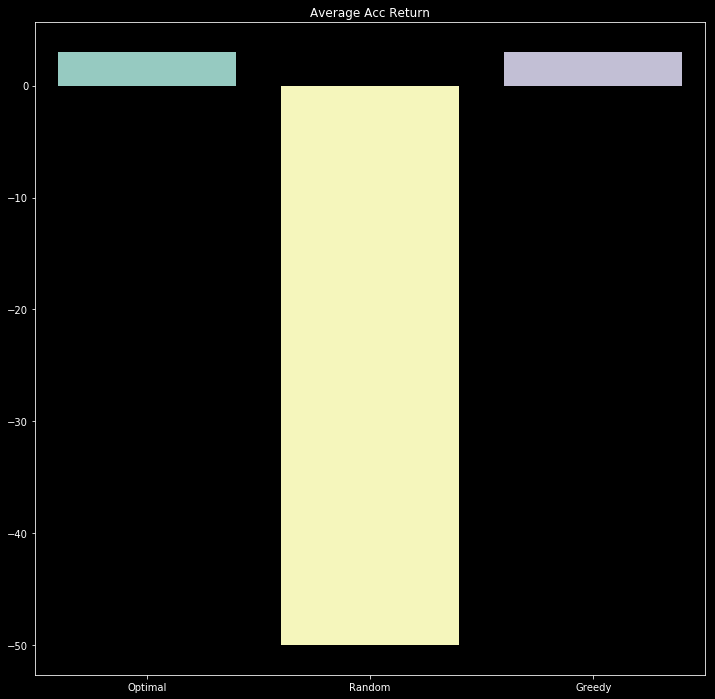

In [279]:

plt.figure(figsize = (12,12))
sns.barplot(data = rewards_df ).set_title('Average Acc Return')


In [234]:
print(ran_path)

[(6, 0), (6, 1), (5, 1), (6, 1), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (5, 4), (6, 4), (6, 3), (6, 4), (5, 4), (6, 4), (6, 3), (6, 2), (6, 1), (5, 1), (5, 2), (5, 1), (4, 1), (3, 1), (3, 2), (3, 3), (3, 3), (3, 3), (3, 4), (3, 5), (3, 4), (3, 3), (3, 4), (3, 4), (3, 4), (3, 5), (4, 5), (3, 5), (3, 5), (3, 6), (4, 6), (3, 6), (3, 6), (4, 6), (3, 6), (3, 5), (3, 5), (4, 5), (4, 4), (4, 3), (3, 3), (3, 2)]


In [290]:

from PIL import Image, ImageDraw

if __name__ == '__main__':
    height = 700
    width = 700
    image = Image.new(mode='RGB', size=(height, width), color=(255,255,255))

    # Draw some lines
    draw = ImageDraw.Draw(image)
    y_start = 0
    y_end = image.height
    step_size = int(image.width / 7)

    for x in range(0, image.width, step_size):
        line = ((x, y_start), (x, y_end))
        draw.line(line, fill=128)

    x_start = 0
    x_end = image.width

# draw text, half opacity

    for y in range(0, image.height, step_size):
        line = ((x_start, y), (x_end, y))
        draw.line(line, fill=128)
    for i,state in enumerate(opt_path[:-1]):
        line = ((state[1]*100+50,state[0]*100+50),(opt_path[i+1][1]*100+50,opt_path[i+1][0]*100+50))
        draw.line(line,fill='red',width = 10)
        draw.text((state[1]*100+i,state[0]*100+20+i),str(i),fill='red')
    for i,state in enumerate(gre_path[:-1]):
        line = ((state[1]*100+40,state[0]*100+40),(gre_path[i+1][1]*100+40,gre_path[i+1][0]*100+40))
        draw.line(line,fill='green',width = 10)
        draw.text((state[1]*100+10+i,state[0]*100+10+i),str(i),fill='green')
    for i,state in enumerate(ran_path[:-1]):
        line = ((state[1]*100+30,state[0]*100+30),(ran_path[i+1][1]*100+30,ran_path[i+1][0]*100+30))
        draw.line(line,fill='blue',width = 5)
        ii = str(i)+' '
        draw.text((state[1]*100,state[0]*100),ii,fill = 'blue')
    #draw.line(((0,0),(600,600)),fill=128,width = 10)
    draw.line(((0,250),(600,250)),fill = 'black',width = 100)
    draw.text((0,0),'Optimal Path',fill='red')
    draw.text((0,20),'Random Path',fill='blue')
    draw.text((0,40),'Greedy Path',fill='green')
    del draw

    image.save('Path_Taken.jpeg')

In [230]:
image = Image.new?
#(mode='L', size=(height, width), color=255)

    # Draw some lines
#draw = ImageDraw.Draw?


Signature: Image.new(mode, size, color=0)
Docstring:
Creates a new image with the given mode and size.

:param mode: The mode to use for the new image. See:
   :ref:`concept-modes`.
:param size: A 2-tuple, containing (width, height) in pixels.
:param color: What color to use for the image.  Default is black.
   If given, this should be a single integer or floating point value
   for single-band modes, and a tuple for multi-band modes (one value
   per band).  When creating RGB images, you can also use color
   strings as supported by the ImageColor module.  If the color is
   None, the image is not initialised.
:returns: An :py:class:`~PIL.Image.Image` object.
File:      c:\users\user\anaconda3\lib\site-packages\pil\image.py
Type:      function


In [261]:
x = np.zeros((7,7))-1
x[0,0] = 20
x[2,0:6] = 0
x

array([[20., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [263]:
xx = [[20., 19., 18., 17, 16, 15, 14],
       [19, 18., 17, 16, 15, 14, 13],
       [ 0.,  0.,  0.,  0.,  0.,  0., 12],
       [5, 6, 7, 8, 9, 10, 11],
       [4, 5, 6, 7, 8, 9, 10],
       [3, 4, 5, 6, 7, 8, 9],
       [2, 3, 4, 5, 6, 7, 8]]

In [265]:
xx_pad = np.pad(xx, 1, mode='constant')

In [266]:
xx_pad

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 20., 19., 18., 17., 16., 15., 14.,  0.],
       [ 0., 19., 18., 17., 16., 15., 14., 13.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.],
       [ 0.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.],
       [ 0.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.],
       [ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  0.],
       [ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])